In [8]:
import sys 
import os
sys.path.append(os.path.abspath("py/"))
import freddie_segment_and_cluster as fred


In [9]:
for tint_lines in fred.generate_tint_lines("output/results/N1_debug/freddie.split"):
    tint = fred.Tint(tint_lines)
    if 10 < len(tint.reads) < 20:
        break


In [10]:
# cints = fred.canonInts(tint.reads)
# for idx, read in enumerate(tint.reads):
#     if read.polyAs[0].length:
#         print(idx, cints.ridx_to_polyA_slacks[idx][0], read.polyAs[0])

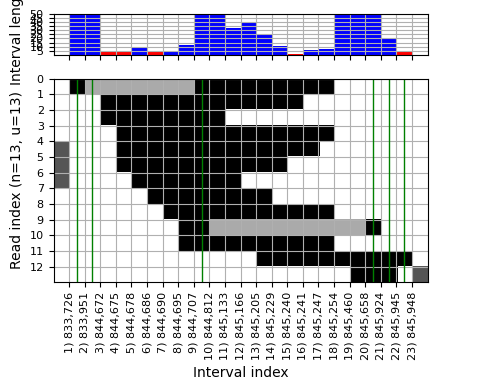

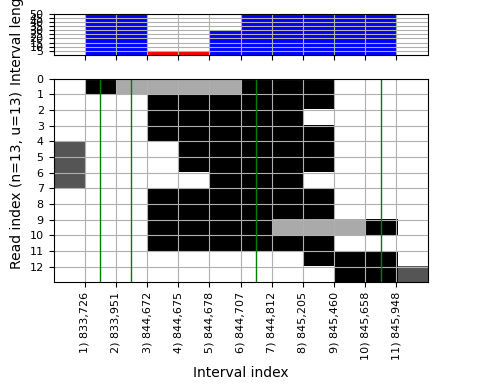

In [11]:
cints = fred.canonInts(tint.reads)
cints.plot(figsize=(5, 4), unique=False)

cints.extend()
cints.compress()
cints.compute_matrix()
cints.plot(figsize=(5, 4), unique=False)

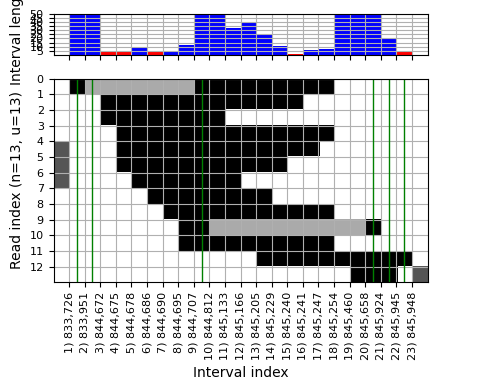

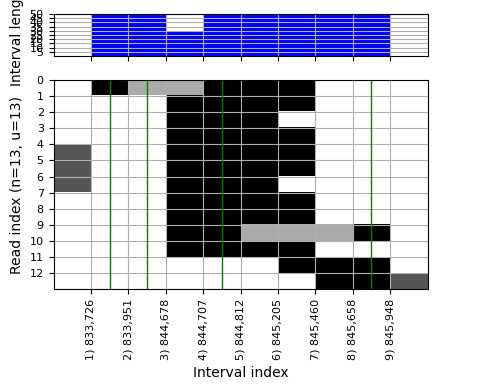

In [12]:
cints = fred.canonInts(tint.reads)
cints.plot(figsize=(5, 4), unique=False)

for i in range(10):
    cints.pop(i)
cints.compute_matrix()
cints.plot(figsize=(5, 4), unique=False)

In [13]:
row_to_ridxs = fred.defaultdict(list)
for idx, row in enumerate(cints.get_matrix()):
    row_to_ridxs[tuple(row)].append(idx)


X, Y = zip(*row_to_ridxs.items())
X[1][1] = 123

TypeError: 'tuple' object does not support item assignment